In [17]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

df = pd.read_csv("train.tsv", header=None, sep="\t", names=[
    'ID', 'Label', 'Statement', 'Subject', 'Speaker', 'Job', 'State', 'Party',
    'Barely True', 'False', 'Half True', 'Mostly True', 'Pants On Fire', 'Context'])

df.head()
    

,ID,Label,Statement,Subject,Speaker,Job,State,Party,Barely True,False,Half True,Mostly True,Pants On Fire,Context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


republican: 4497
democrat: 3336
none: 1744
organization: 219
independent: 147
columnist: 35
activist: 39
talk-show-host: 26
libertarian: 40
newsmaker: 56
journalist: 38
labor-leader: 11
state-official: 20
business-leader: 9
education-official: 2
tea-party-member: 10
green: 3
liberal-party-canada: 1
government-body: 1
Moderate: 1
democratic-farmer-labor: 1
ocean-state-tea-party-action: 1
constitution-party: 1


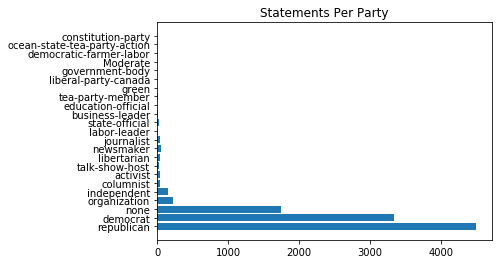

In [35]:
parties = pd.unique(df['Party'].dropna())
x_axis = np.arange(len(parties))
y_axis = []
for p in parties:
    count = 0
    for q in df['Party']:
        if q == p:
            count = count + 1
            
    y_axis.append(count)
    print("{}: {}".format(p, count))
    
plt.barh(parties, y_axis)
plt.title('Statements Per Party')
plt.show()

In [33]:
#  Truth breakdown of each speaker
list_speakers = list(dict.fromkeys(df.dropna()['Speaker']))

pf_data = []  # pants on fire
f_data = []  # false
bt_data = []  # barely true
ht_data = []  # half true
mt_data = []  # mostly true
t_data = []  # true

for s in list_speakers:
    is_s = df['Speaker'] == s
    
    total_count = 0  # might use this later
    pf_count = 0
    f_count = 0
    bt_count = 0
    ht_count = 0
    mt_count = 0
    t_count = 0
    
    for l in df[is_s]['Label']:
        total_count = total_count + 1
        if l == 'pants-fire': pf_count = pf_count + 1
        elif l == 'false': f_count = f_count + 1
        elif l == 'barely-true': bt_count = bt_count + 1
        elif l == 'half-true': ht_count = ht_count + 1
        elif l == 'mostly-true': mt_count = mt_count + 1
        elif l == 'true': t_count = t_count + 1
        elif l == 'NaN': total_count = total_count - 1
            
    pf_data.append(pf_count)
    f_data.append(f_count)
    bt_data.append(bt_count)
    ht_data.append(ht_count)
    mt_data.append(mt_count)
    t_data.append(t_count)
    
fig = go.Figure(data=go.Table(header=dict(values=['Speaker','Pants On Fire','False','Barely True','Half True','Mostly True','True']),
    cells=dict(values=[list_speakers, pf_data, f_data, bt_data, ht_data, mt_data, t_data])))
fig.show()